In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader 
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import copy
import time
import gc
import matplotlib.pyplot as plt
import numpy as np
import warnings
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf

In [ ]:
NUM_CLASSES = 101
BATCH_SIZE = 16    
STEP_SIZE = 25
LR = 1e-4   
TRAIN_SIZE = 0.5    
epoch_number = 10

In [ ]:
mean, stdev = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev) 
                                    ])


eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev)                             
                                    ])

In [ ]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
            
def initialize_resnet18(use_pretrained=True, frz=True):
    """ Resnet18
    """
    net = resnet18(pretrained=use_pretrained)
    if frz:
        freeze(net)

    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, NUM_CLASSES)

    return net

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def save_modell(net, criterion, optimizer, PATH_PT):
    torch.save({
    'model_state_dict': net.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, PATH_PT)

def load_modell(net, PATH_PT):
    checkpoint = torch.load(PATH_PT, map_location=DEVICE)

    net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)
    net = net.to(DEVICE)

    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

    net.load_state_dict(checkpoint['model_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return net, criterion, optimizer


# CNN

In [ ]:
path = '/content/drive/MyDrive/caltech-101/101_ObjectCategories'

In [ ]:
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
batch_size = 32
img_height = 256
img_width = 256

8677


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8677 files belonging to 101 classes.
Using 6942 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8677 files belonging to 101 classes.
Using 1735 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [ ]:
print(len(class_names))

101


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008224667 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
     tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
     tf.keras.layers.RandomRotation(0.1),
     tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath='/content/drive/MyDrive/callbacks',
 save_best_only=True,
 monitor="val_loss")

]

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks = callbacks
)

Epoch 1/20
217/217 [==============================] - 910s 4s/step - loss: 3.6037 - accuracy: 0.2635 - val_loss: 3.0163 - val_accuracy: 0.3654
Epoch 2/20
217/217 [==============================] - 45s 208ms/step - loss: 2.8145 - accuracy: 0.3917 - val_loss: 2.5501 - val_accuracy: 0.4490
Epoch 3/20
217/217 [==============================] - 45s 207ms/step - loss: 2.3705 - accuracy: 0.4602 - val_loss: 2.3287 - val_accuracy: 0.4888
Epoch 4/20
217/217 [==============================] - 45s 208ms/step - loss: 2.0762 - accuracy: 0.5069 - val_loss: 2.1185 - val_accuracy: 0.5314
Epoch 5/20
217/217 [==============================] - 45s 207ms/step - loss: 1.9212 - accuracy: 0.5447 - val_loss: 2.1013 - val_accuracy: 0.5331
Epoch 6/20
217/217 [==============================] - 45s 207ms/step - loss: 1.7371 - accuracy: 0.5792 - val_loss: 2.0756 - val_accuracy: 0.5412
Epoch 7/20
217/217 [==============================] - 42s 191ms/step - loss: 1.6282 - accuracy: 0.6005 - val_loss: 2.1015 - val_accu

In [ ]:
model.save('/content/drive/MyDrive/models/') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/models/')

# Check its architecture
new_model.summary()
loss, acc = new_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(val_ds).shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [ ]:
scores = new_model.evaluate(val_ds, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

55/55 [==============================] - 4s 73ms/step - loss: 1.9684 - accuracy: 0.6081
Accuracy: 60.81%


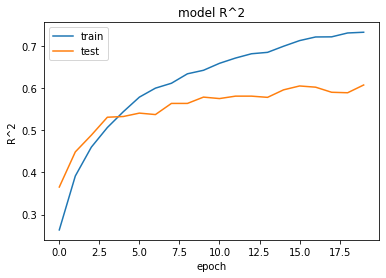

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



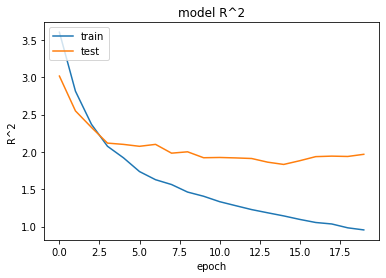

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
images = []
labels = []
for image, label in value_dataset.take(-1):
  images.extend(image)
  labels.extend(label)
images = np.array(images)
labels = np.array(labels)

predictions = model.predict(images)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

classification_report(labels, predictions, target_names=class_names)

              precision    recall  f1-score   support

           0       0.5       0.59      0.47       145
           1       0.59      0.55      0.47       145
           2       0.47      0.40      0.49        67
           3       0.49      0.50      0.99       266
           4       0.45      0.50      0.47        19
           5       0.45      0.40      0.48       266
           6       0.47      0.53      0.42        14
           7       0.45      0.46      0.40        14
           8       0.40      0.54      0.47        16
           9       0.48      0.48      0.48        18
          10       0.47      0.50      0.47        15
          11       0.40      0.52      0.40        11
          12       0.43      0.58      0.45        43
          13       0.48      0.57      0.46        33
          14       0.44      0.40      0.46        14
          15       0.43      0.40      0.41        28
          16       0.40      0.57      0.43        31
          17       0.47    

# **Prepare**

In [ ]:
from torchvision.datasets import VisionDataset, ImageFolder
from PIL import Image

import numpy as np
import os.path
import sys

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/'
from Caltech101.caltech_dataset import Caltech

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None, split='train', transform='None') : 
    # dir = 'Caltech101'
    images = []
    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return x.lower().endswith(extensions)

    inputFile = os.path.join(dir, split + '.txt') # 'Caltech101/{split}.txt'
    with open(inputFile, 'r') as f:      
      input_images = f.read().splitlines()

    root = os.path.join(dir, '101_ObjectCategories/') # 'Caltech101/101_ObjectCategories/'

    for fname in input_images:
      fpath = os.path.split(fname)
      # print(fpath) # 'accordion' 'image_0002.jpg'
      target = fpath[0] # 'accordion'
      path = os.path.join(root, fname) # 'Caltech101/101_ObjectCategories/accordion/image_0002.jpg'
      if is_valid_file(path) and target != 'BACKGROUND_Google':
        item = (path, class_to_idx[target])
        images.append(item)

    return images # paths

class Caltech(VisionDataset):
    ''' Caltech 101 Dataset '''

    def __init__(self, root, split='train', transform=None, target_transform=None):
        '''
          Args:
            root (string): Directory with all the images.
            split (string): Defines the split you are going to use (split files are called 'train.txt' and 'test.txt').
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional trasform to be applied on the target labels (not used).
        '''
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        self.split = split
        
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, IMG_EXTENSIONS, split=self.split, transform=transform)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))

        self.loader = pil_loader
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):        
        root = os.path.join(dir, '101_ObjectCategories/')
        classes = [d.name for d in os.scandir(root) if d.is_dir()]
        classes.remove('BACKGROUND_Google')
        classes.sort()                
        #print(classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        #print(class_to_idx)
        return classes, class_to_idx

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''
        path, label = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            image = self.transform(sample)

        return image, label

    def __len__(self):   
        '''
        The __len__ method returns the length of the dataset
        '''     
        return len(self.samples)


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


# Useful variables to plot distribution number of images per category
class_to_idx = train_dataset.class_to_idx
trainlabels = train_dataset.targets 
testlabels = test_dataset.targets
all_labels = trainlabels + testlabels

from sklearn.model_selection import StratifiedShuffleSplit

# split the train_dataset in train and val  
sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, random_state=42)

X = [img[0] for img in train_dataset.samples]
y = [lab[1] for lab in train_dataset.samples]

for train_idx, val_idx in sss.split(X,y) :
  train_indexes = train_idx
  val_indexes = val_idx

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print(f"Train Dataset:\t{len(train_dataset)}")
print(f"Valid Dataset:\t{len(val_dataset)}")
print(f"Test Dataset:\t{len(test_dataset)}")

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.
Train Dataset:	2892
Valid Dataset:	2892
Test Dataset:	2893


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224]) torch.Size([16])
tensor(87)


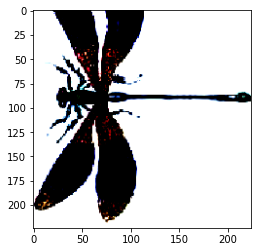

In [ ]:
for X, y in val_dataloader:
    print(X.size(), y.size())
    print(y[5])
    plt.imshow(X[10].permute(1, 2, 0))
    break

# **Frozen pre-trained ResNet**

**Prepare Network**


In [ ]:
new_model = False
PATH_PT = '/content/drive/MyDrive/resnet18-checkpoint.pt'

if new_model == True:
    net = initialize_resnet18(use_pretrained=True)

    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

    save_modell(net, criterion, optimizer, PATH_PT)

else:
    net, criterion, optimizer = load_modell(resnet18(pretrained=True), PATH_PT)

In [ ]:
print(net)
for param in net.parameters():
    print(param.requires_grad)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train**

In [ ]:
start = time.time()
net = net.to(DEVICE) 

# save best config
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []


for epoch in range(epoch_number):
  print(f"Epoch  {epoch+1}/{epoch_number}")
  print('-' * 15)
  current_step = 0
  
  net.train() # Sets module in training mode

  running_corrects_train = 0
  running_loss_train = 0.0

  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
  	
    with torch.set_grad_enabled(True):

      outputs_train = net(images)
      _, preds = torch.max(outputs_train, 1)

      loss = criterion(outputs_train, labels)

      if current_step % STEP_SIZE == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward() 
      optimizer.step() 

    current_step += 1

  # store loss and accuracy values
  running_corrects_train += torch.sum(preds == labels.data).data.item() 
  running_loss_train += loss.item() * images.size(0)
  
  train_acc = running_corrects_train / float(len(train_dataset))
  train_loss = running_loss_train / float(len(train_dataset))

  train_accuracies.append(train_acc)
  train_losses.append(train_loss)

  ### END TRAINING PHASE OF AN EPOCH

  # Evaluate accuracy on the validation set after each epoch
  net.train(False) # Set Network to evaluation mode

  running_corrects_val = 0
  running_loss_val = 0.0

  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
      outputs = net(images)
      _, preds = torch.max(outputs, 1)

      running_corrects_val += torch.sum(preds == labels.data).data.item()
      loss = criterion(outputs.data, labels)

    # Update Corrects and Loss
    running_loss_val += loss.item() * images.size(0)
    running_corrects_val += torch.sum(preds == labels.data)

  # Compute epoch loss and accuracy
  val_loss = running_loss_val / float(len(val_dataset))
  val_acc = running_corrects_val / float(len(val_dataset))

  # memorize stats 
  val_losses.append(val_loss)
  val_accuracies.append((val_acc-1)*100)

  print("Validation Accuracy: {:.3f}%".format((val_acc-1)*100))

  # Check if the current epoch val accuracy is better than the best found until now
  if (val_acc >= best_val_acc) : 
    best_val_acc = val_acc
    best_epoch = epoch
    best_net = copy.deepcopy(net) # deep copy the model


print(f"\nBest epoch: {best_epoch+1}\n{(best_val_acc-1)*100}% (Validation Accuracy)\n")
print(f">>> Time elapsed {(time.time()-start)/60:.2f} minutes")


Epoch  1/10
---------------
Step 0, Loss 1.8648194074630737
Step 25, Loss 1.3553417921066284
Step 50, Loss 0.9903777837753296
Step 75, Loss 0.6588577032089233
Step 100, Loss 0.851163923740387
Step 125, Loss 0.8039879202842712
Step 150, Loss 0.525955080986023
Step 175, Loss 0.625338613986969
Validation Accuracy: 71.853%
Epoch  2/10
---------------
Step 0, Loss 0.21357855200767517
Step 25, Loss 0.4468412399291992
Step 50, Loss 0.3393787145614624
Step 75, Loss 0.2659522593021393
Step 100, Loss 0.42981046438217163
Step 125, Loss 0.8731567859649658
Step 150, Loss 0.5791118741035461
Step 175, Loss 0.6389929056167603
Validation Accuracy: 76.625%
Epoch  3/10
---------------
Step 0, Loss 0.3692835569381714
Step 25, Loss 0.3026011288166046
Step 50, Loss 0.2810387909412384
Step 75, Loss 0.41845643520355225
Step 100, Loss 0.3809794485569
Step 125, Loss 0.1429443061351776
Step 150, Loss 0.24426111578941345
Step 175, Loss 0.17943039536476135
Validation Accuracy: 78.976%
Epoch  4/10
---------------
S

Learning curves

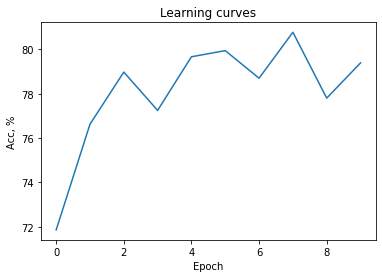

In [ ]:
val_acc = []
for v in val_accuracies:
    val_acc.append(v.item())

plt.xlabel('Epoch')
plt.ylabel('Acc, %')
plt.title('Learning curves')
plt.plot(val_acc)

In [ ]:
save_best_net = True

if save_best_net == True:
    net = copy.deepcopy(best_net)
    save_modell(net, criterion, optimizer, PATH_PT)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


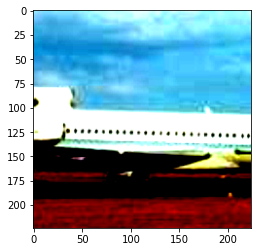

In [ ]:
import cv2

# load one batch of testing images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)

plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

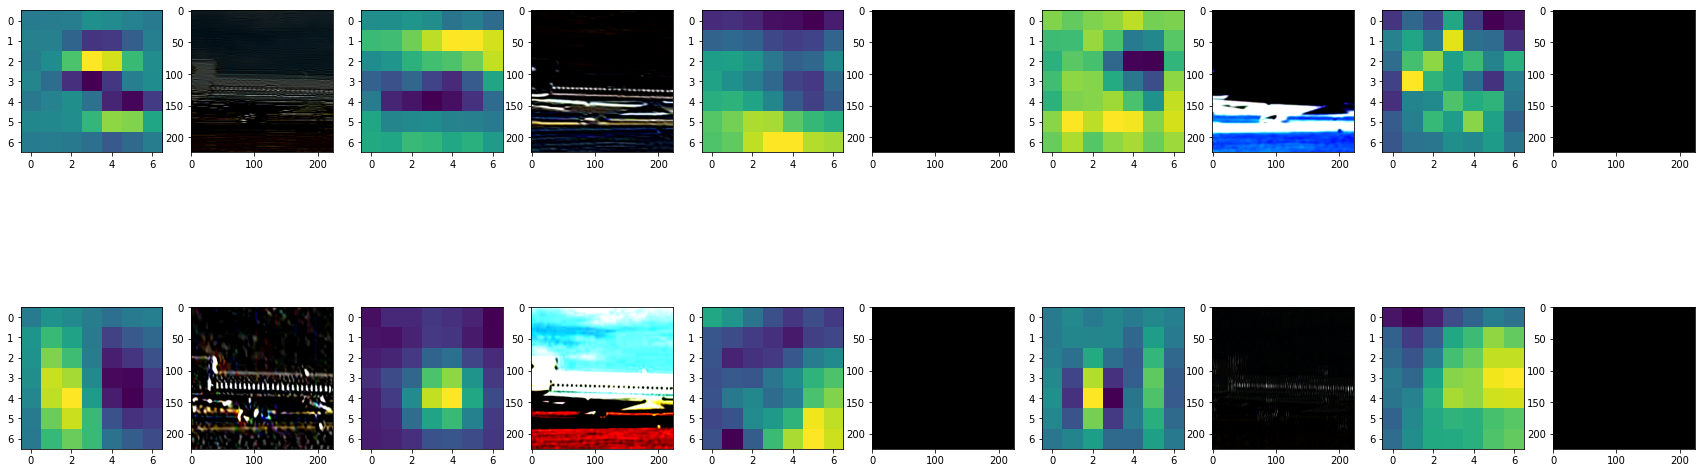

In [ ]:
# first conv layer - for 10 filters
weights = net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

**Validation**

In [ ]:
net = net.to(DEVICE)
net.train(False)

running_corrects = 0
y_train_arr = []
x_train_arr = []

for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)

  x_train_arr.append(images)
  y_train_arr.append(labels.data)

  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(val_dataset))

print("\n")
print('Validation Accuracy: {}%'.format(accuracy*100))

100%|██████████| 181/181 [00:14<00:00, 12.48it/s]



Validation Accuracy: 90.31811894882435%


**Test**

In [ ]:
net = net.to(DEVICE)
net.train(False) 

running_corrects = 0
y_trues_arr = []
y_preds_arr = []
x_trues_arr = []

for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)
  y_preds_arr.append(preds)

  x_trues_arr.append(images)
  y_trues_arr.append(labels.data)

  running_corrects += torch.sum(preds == labels.data).data.item()
  

accuracy = running_corrects / float(len(test_dataset))

print("\n")
print('Test Accuracy: {}%'.format(accuracy*100))

100%|██████████| 181/181 [00:13<00:00, 13.07it/s]



Test Accuracy: 91.35845143449706%


In [ ]:
gc.collect()

2528

In [ ]:
def flat(y_ls):
    flat_list = [item.cpu() for sublist in y_ls for item in sublist]
    return torch.stack(flat_list).numpy()

y_pred = flat(y_preds_arr)
y_true = flat(y_trues_arr) # == y_test
x_true = flat(x_trues_arr) # == x_test
gc.collect()
y_train = flat(y_train_arr) 
x_train = flat(x_train_arr) 

In [ ]:
PATH_V = '/content/drive/MyDrive/resnet18-values.pt'

def save_values(x_true, y_true, y_pred, x_train, y_train, PATH_V):
    torch.save({
    'x_true': x_true,
    'y_true': y_true,
    'y_pred': y_pred,
    'x_train': x_train,
    'y_train': y_train,}, PATH_PT)

def load_values(PATH_V):
    checkpoint = torch.load(PATH_V, map_location=DEVICE)

    x_true = checkpoint['x_true']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    x_train = checkpoint['x_train']
    y_train = checkpoint['y_train']

    return x_true, y_true, y_pred, x_train, y_train

In [ ]:
x_train.shape

(2892, 3, 224, 224)

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       145
           1       0.99      0.95      0.97       145
           2       0.97      1.00      0.99        67
           3       0.99      1.00      0.99       266
           4       0.95      1.00      0.97        19
           5       0.95      1.00      0.98       266
           6       0.67      0.43      0.52        14
           7       0.75      0.86      0.80        14
           8       1.00      0.94      0.97        16
           9       0.78      0.78      0.78        18
          10       0.57      0.80      0.67        15
          11       1.00      0.82      0.90        11
          12       0.93      0.98      0.95        43
          13       0.78      0.97      0.86        33
          14       0.64      0.50      0.56        14
          15       0.93      1.00      0.97        28
          16       1.00      0.87      0.93        31
          17       0.87    

Reshape

In [ ]:
def rgb2gray(rgb):
       return (0.2126*rgb[0,:,:]+0.7152*rgb[1,:,:]+0.0722*rgb[2,:,:])

def convert_reshape(x_train_or_test):
    long_list = [item for sublist in x_train_or_test for item in sublist]

    matrices_list = []
    for i in range(len(long_list)):
        matrices_list.append(rgb2gray(long_list[i])) 

    flat_list = []
    for i in range(len(matrices_list)):
        flat_list.append(matrices_list[i].flatten().numpy()) 

    del long_list
    del matrices_list

    return flat_list


In [ ]:
X_train = []
y_train = []
for x, y in tqdm(train_dataloader):
    X_train.append(x)
    y_train.append(y)

100%|██████████| 180/180 [00:12<00:00, 14.15it/s]


In [ ]:
X_test = []
y_test = []
for x, y in tqdm(test_dataloader):
    X_test.append(x)
    y_test.append(y)

100%|██████████| 181/181 [00:12<00:00, 14.96it/s]


In [ ]:
X_train_flat = np.array(convert_reshape(X_train))
gc.collect()

X_test_flat = np.array(convert_reshape(X_test))

y_train = [item for sublist in y_train for item in sublist]
y_test = [item for sublist in y_test for item in sublist]

y_train_flat = np.array(y_train)
y_test_flat = np.array(y_test)

In [ ]:
gc.collect()

7788

In [ ]:
print(X_train_flat.shape)
print(X_test_flat.shape)

print(y_train_flat.shape)
print(y_test_flat.shape)

(2880, 50176)
(2893, 50176)
(2880,)
(2893,)


Confusion matrix

In [ ]:
labels = np.unique(all_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

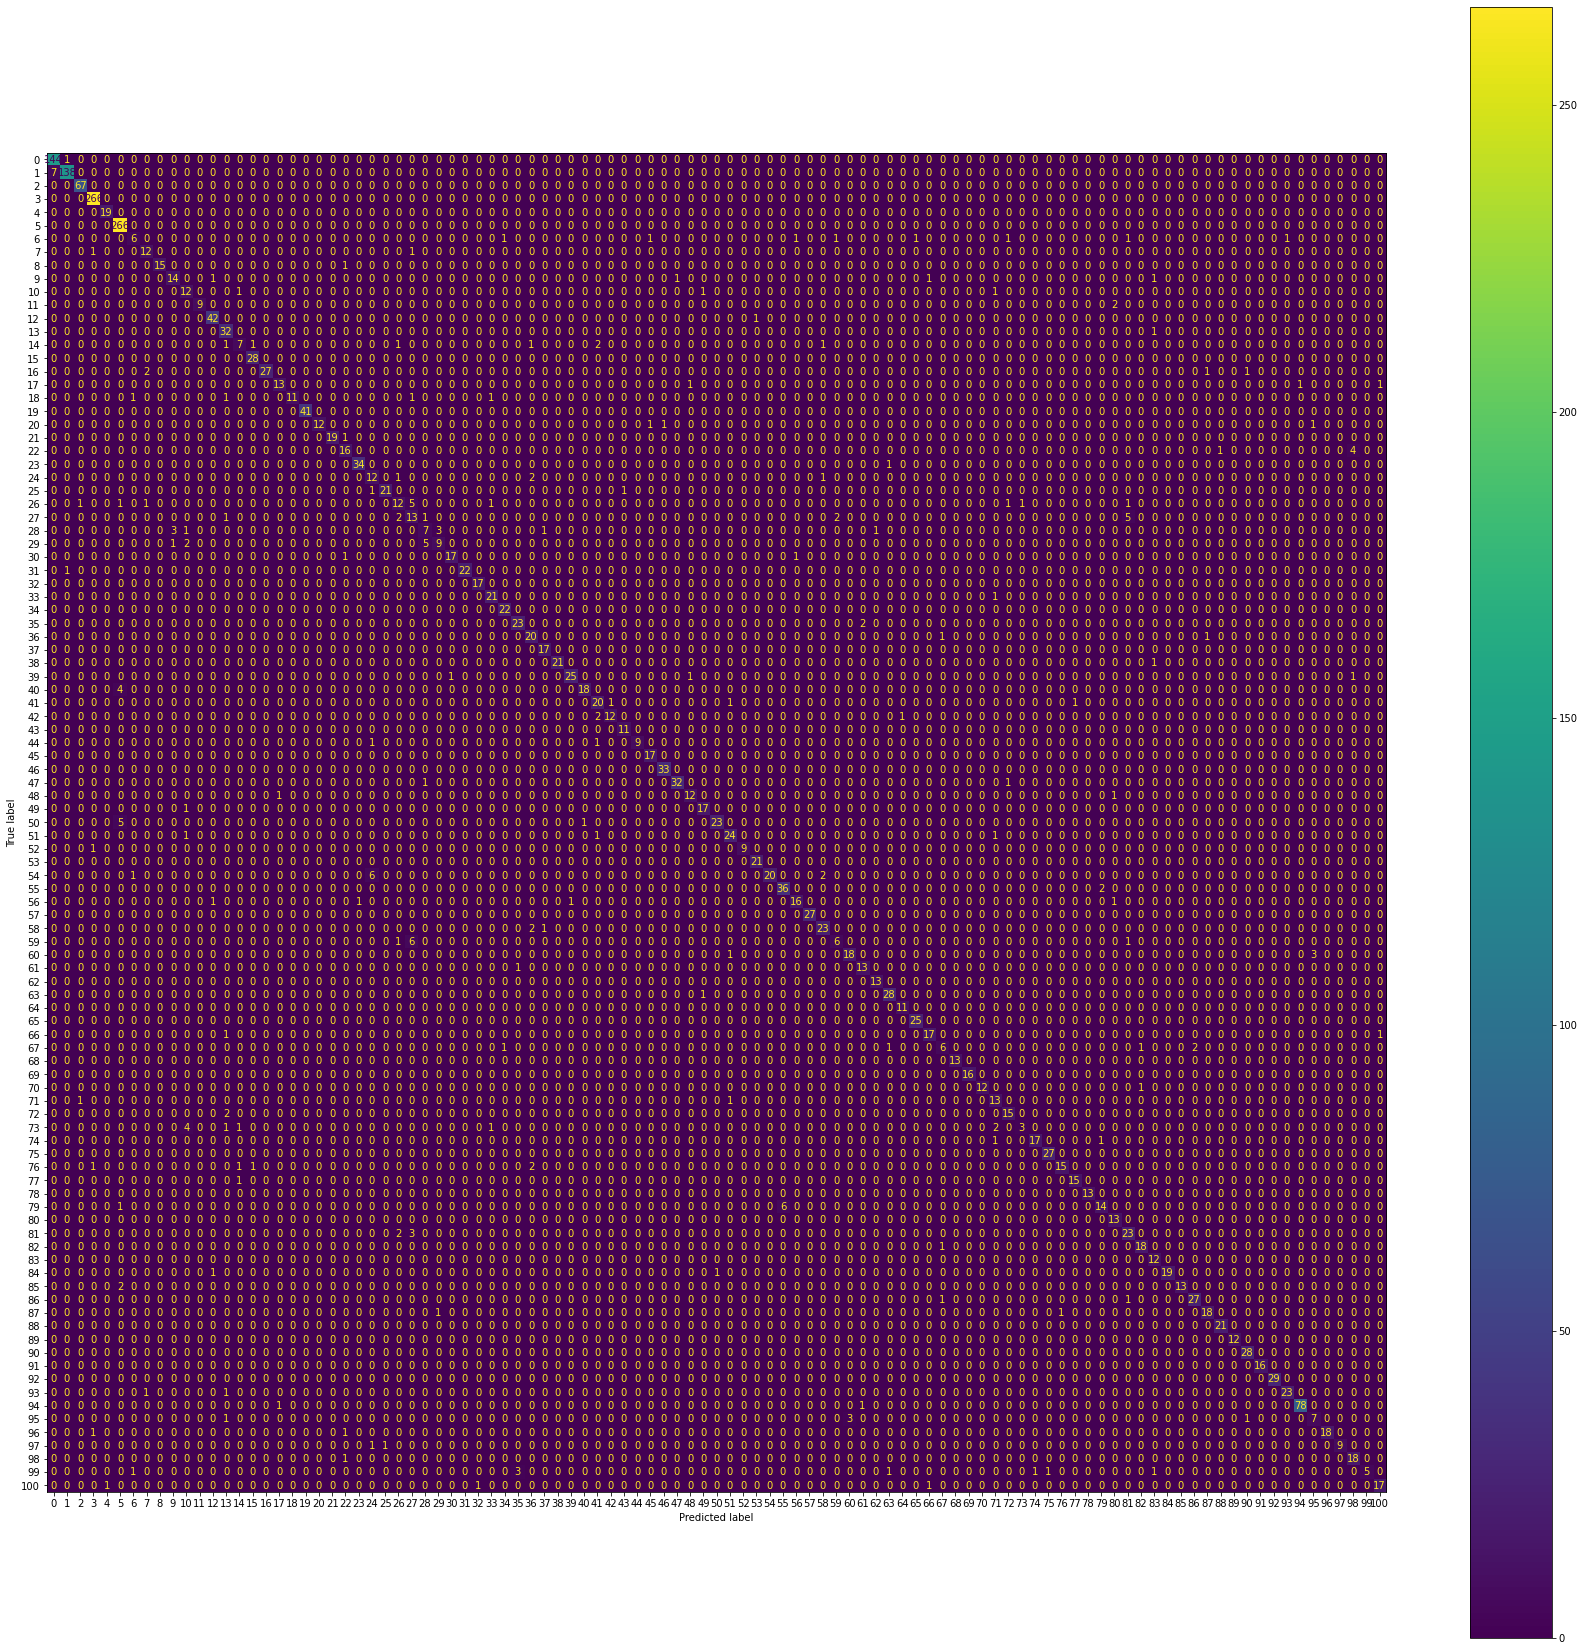

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)

In [ ]:
gc.collect()

88

ROC Curve plot

In [ ]:
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = NUM_CLASSES

In [ ]:
train_un = np.unique(y_train)

y_test = y_true
test_un = np.unique(y_test)

# Binarize the output
y_train = label_binarize(y_train, classes=train_un)
y_test = label_binarize(y_test, classes=test_un)

n_classes = y_test.shape[1]

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = label_binarize(y_pred, classes=test_un)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[i, :], y_score[i, :])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

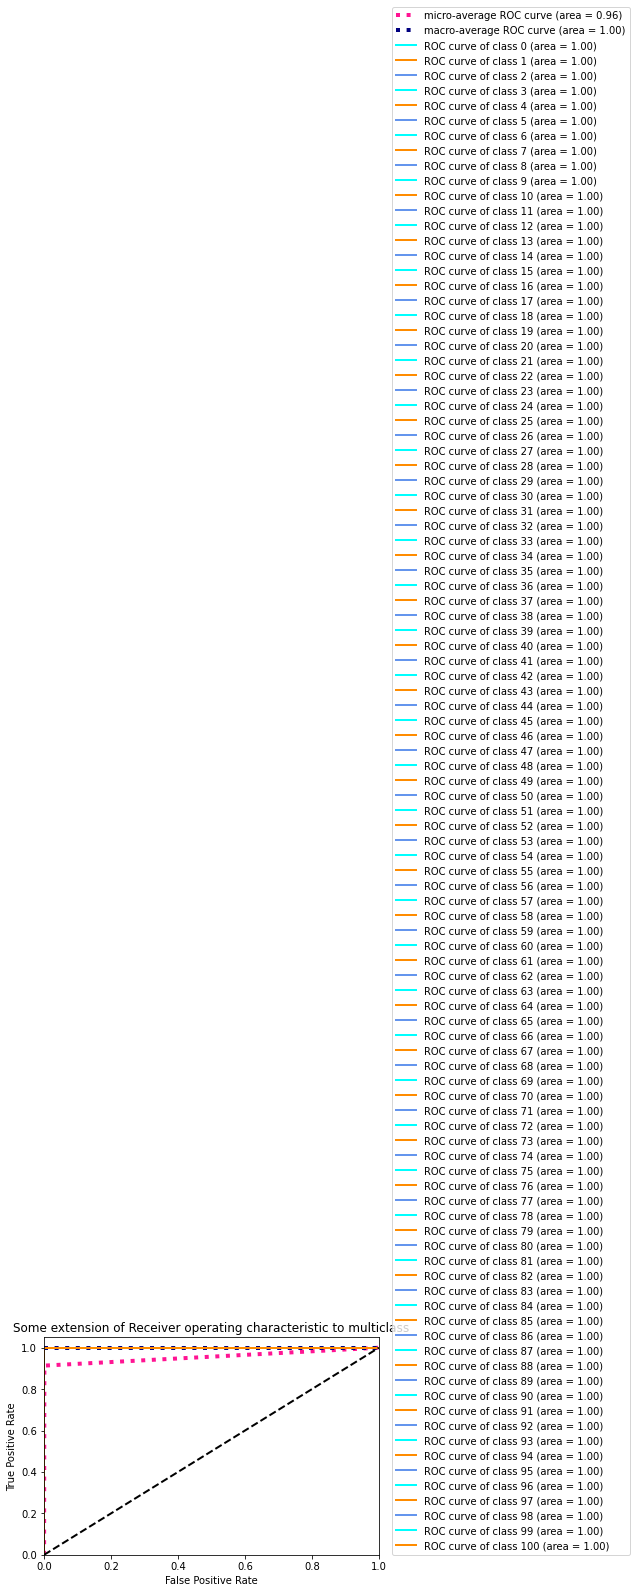

In [ ]:
lw = 2

plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc=(1.04,0))
plt.show()

In [ ]:
y_prob = y_score

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "\nOne-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "\nOne-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)


One-vs-One ROC AUC scores:
0.932826 (macro),
0.956118 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.932826 (macro),
0.956118 (weighted by prevalence)


In [ ]:
gc.collect()

32328

AUC-PRC plot

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

y_score = label_binarize(y_pred, classes=test_un)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

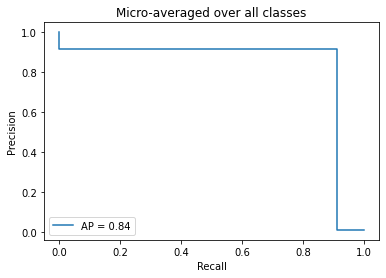

In [ ]:
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

The top-1 error rate in %

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
error_rate = 1 - accuracy

print("Error rate: {:.3}%".format(error_rate*100))

Error rate: 8.64%


Visualize model

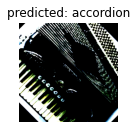

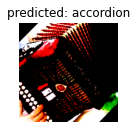

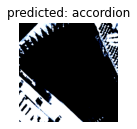

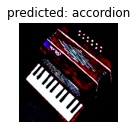

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    X, y = [], []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
           
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')

                    name = list(class_to_idx.keys())[list(class_to_idx.values()).index(preds[j])]
                    ax.set_title(f'predicted: {name}')
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

visualize_model(net)

# **Fine-tuned pre-trained ResNet**

**Prepare Network**


In [ ]:
new_model = False
PATH_PT = '/content/drive/MyDrive/finetuned-checkpoint.pt'

if new_model == True:
    net = initialize_resnet18(use_pretrained=True, frz=False)

    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

    save_modell(net, criterion, optimizer, PATH_PT)

else:
    net, criterion, optimizer = load_modell(resnet18(pretrained=True), PATH_PT)

In [ ]:
# print the chosen network
print(net)
for param in net.parameters():
    print(param.requires_grad)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train**

In [ ]:
start = time.time()
net = net.to(DEVICE) 

# save best config
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []


for epoch in range(epoch_number):
  print(f"\nEpoch  {epoch+1}/{epoch_number}")
  print('-' * 15)
  current_step = 0
  
  net.train() # Sets module in training mode

  running_corrects_train = 0
  running_loss_train = 0.0

  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
  	
    with torch.set_grad_enabled(True):

      outputs_train = net(images)
      _, preds = torch.max(outputs_train, 1)

      loss = criterion(outputs_train, labels)

      if current_step % STEP_SIZE == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward() 
      optimizer.step() 

    current_step += 1

  # store loss and accuracy values
  running_corrects_train += torch.sum(preds == labels.data).data.item() 
  running_loss_train += loss.item() * images.size(0)
  
  train_acc = running_corrects_train / float(len(train_dataset))
  train_loss = running_loss_train / float(len(train_dataset))

  train_accuracies.append(train_acc)
  train_losses.append(train_loss)

  ### END TRAINING PHASE OF AN EPOCH

  # Evaluate accuracy on the validation set after each epoch
  net.train(False) # Set Network to evaluation mode

  running_corrects_val = 0
  running_loss_val = 0.0

  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
      outputs = net(images)
      _, preds = torch.max(outputs, 1)

      running_corrects_val += torch.sum(preds == labels.data).data.item()
      loss = criterion(outputs.data, labels)

    # Update Corrects and Loss
    running_loss_val += loss.item() * images.size(0)
    running_corrects_val += torch.sum(preds == labels.data)

  # Compute epoch loss and accuracy
  val_loss = running_loss_val / float(len(val_dataset))
  val_acc = running_corrects_val / float(len(val_dataset))

  # memorize stats 
  val_losses.append(val_loss)
  val_accuracies.append((val_acc-1)*100)

  print("Validation Accuracy: {:.3f}%".format((val_acc-1)*100))

  # Check if the current epoch val accuracy is better than the best found until now
  if (val_acc >= best_val_acc) : 
    best_val_acc = val_acc
    best_epoch = epoch
    best_net = copy.deepcopy(net) # deep copy the model


print(f"\nBest epoch: {best_epoch+1}\n{(best_val_acc-1)*100}% (Validation Accuracy)\n")
print(f">>> Time elapsed {(time.time()-start)/60:.2f} minutes")



Epoch  1/10
---------------
Step 0, Loss 0.03947103023529053
Step 25, Loss 0.6092250347137451
Step 50, Loss 0.1383066326379776
Step 75, Loss 0.06827408820390701
Step 100, Loss 0.050601933151483536
Step 125, Loss 0.06404773890972137
Step 150, Loss 0.1904897391796112
Step 175, Loss 0.04716307297348976
Validation Accuracy: 77.801%

Epoch  2/10
---------------
Step 0, Loss 0.0797344222664833
Step 25, Loss 0.09460781514644623
Step 50, Loss 0.026747504249215126
Step 75, Loss 0.05491530895233154
Step 100, Loss 0.08607830852270126
Step 125, Loss 0.031814154237508774
Step 150, Loss 0.11987423896789551
Step 175, Loss 0.03871104121208191
Validation Accuracy: 76.487%

Epoch  3/10
---------------
Step 0, Loss 0.016628174111247063
Step 25, Loss 0.03403719887137413
Step 50, Loss 0.024796897545456886
Step 75, Loss 0.05221531540155411
Step 100, Loss 0.07403445988893509
Step 125, Loss 0.1700066179037094
Step 150, Loss 0.16078698635101318
Step 175, Loss 0.12394886463880539
Validation Accuracy: 73.997%



Learning curves

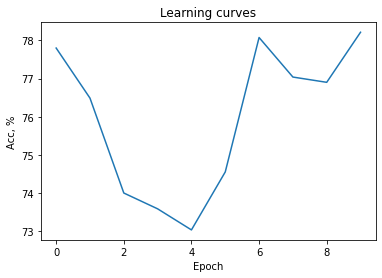

In [ ]:
val_acc = []
for v in val_accuracies:
    val_acc.append(v.item())

plt.xlabel('Epoch')
plt.ylabel('Acc, %')
plt.title('Learning curves')
plt.plot(val_acc)

In [ ]:
save_best_net = True

if save_best_net == True:
    net = copy.deepcopy(best_net)
    save_modell(net, criterion, optimizer, PATH_PT)
    print('Saved')

Saved


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


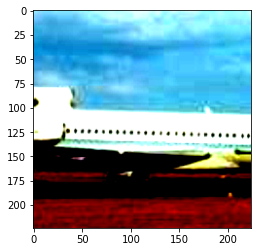

In [ ]:
import cv2

# load one batch of testing images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)

plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

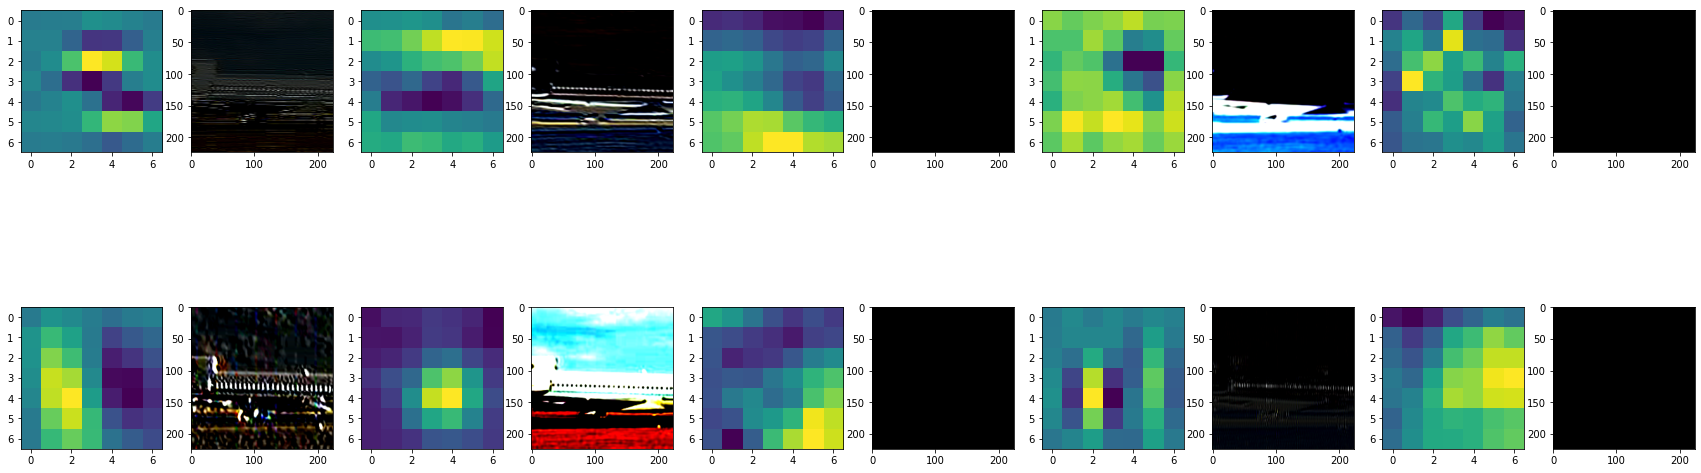

In [ ]:
# first conv layer - for 10 filters
weights = net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

In [ ]:
def flat(y_ls): 
  flat_list = [item.cpu() for sublist in y_ls for item in sublist] 
  return torch.stack(flat_list).numpy()

**Validation**

In [ ]:
net = net.to(DEVICE)
net.train(False)
gc.collect()

running_corrects = 0
y_train_arr = []
x_train_arr = []

for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)

  x_train_arr.append(images)
  y_train_arr.append(labels.data)

  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(val_dataset))

print("\n")
print('Validation Accuracy: {}%'.format(accuracy*100))

100%|██████████| 181/181 [00:18<00:00,  9.74it/s]



Validation Accuracy: 88.93499308437067%


In [ ]:
y_train = flat(y_train_arr)
gc.collect()

x_train = flat(x_train_arr)
gc.collect()

0

**Test**

In [ ]:
net = net.to(DEVICE)
net.train(False) 

running_corrects = 0
y_trues_arr = []
y_preds_arr = []
x_trues_arr = []

for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)
  y_preds_arr.append(preds)

  x_trues_arr.append(images)
  y_trues_arr.append(labels.data)

  running_corrects += torch.sum(preds == labels.data).data.item()
  
accuracy = running_corrects / float(len(test_dataset))

print("\n")
print('Test Accuracy: {}%'.format(accuracy*100))

100%|██████████| 181/181 [00:14<00:00, 12.76it/s]



Test Accuracy: 89.76840649844452%


In [ ]:
y_true = flat(y_trues_arr) # == y_test
gc.collect()

0

In [ ]:
y_pred = flat(y_preds_arr)
gc.collect()

82

In [ ]:
x_true = flat(x_trues_arr) # == x_test
gc.collect()

0

In [ ]:
x_train.shape

(2892, 3, 224, 224)

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       145
           1       0.97      0.99      0.98       145
           2       0.99      1.00      0.99        67
           3       0.98      1.00      0.99       266
           4       0.83      1.00      0.90        19
           5       1.00      0.98      0.99       266
           6       0.77      0.71      0.74        14
           7       1.00      0.71      0.83        14
           8       0.88      0.88      0.88        16
           9       1.00      0.78      0.88        18
          10       0.53      0.67      0.59        15
          11       0.77      0.91      0.83        11
          12       0.84      0.95      0.89        43
          13       0.91      0.94      0.93        33
          14       0.50      0.57      0.53        14
          15       0.90      0.96      0.93        28
          16       1.00      0.74      0.85        31
          17       0.88    

Reshape

In [ ]:
def rgb2gray(rgb):
       return (0.2126*rgb[0,:,:]+0.7152*rgb[1,:,:]+0.0722*rgb[2,:,:])

def convert_reshape(x_train_or_test):
    long_list = [item for sublist in x_train_or_test for item in sublist]

    matrices_list = []
    for i in range(len(long_list)):
        matrices_list.append(rgb2gray(long_list[i])) 

    flat_list = []
    for i in range(len(matrices_list)):
        flat_list.append(matrices_list[i].flatten().numpy()) 

    del long_list
    del matrices_list

    return flat_list


In [ ]:
X_train = []
y_train = []
for x, y in tqdm(train_dataloader):
    X_train.append(x)
    y_train.append(y)

100%|██████████| 180/180 [00:12<00:00, 14.62it/s]


In [ ]:
gc.collect()

88

In [ ]:
X_test = []
y_test = []
for x, y in tqdm(test_dataloader):
    X_test.append(x)
    y_test.append(y)

100%|██████████| 181/181 [00:19<00:00,  9.38it/s]


In [ ]:
X_train_flat = np.array(convert_reshape(X_train))
gc.collect()

X_test_flat = np.array(convert_reshape(X_test))

gc.collect()

y_train = [item for sublist in y_train for item in sublist]
y_test = [item for sublist in y_test for item in sublist]

y_train_flat = np.array(y_train)
y_test_flat = np.array(y_test)

In [ ]:
gc.collect()

131

In [ ]:
print(X_train_flat.shape)
print(X_test_flat.shape)

print(y_train_flat.shape)
print(y_test_flat.shape)

(2880, 50176)
(2893, 50176)
(2880,)
(2893,)


Confusion matrix

In [ ]:
labels = np.unique(all_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

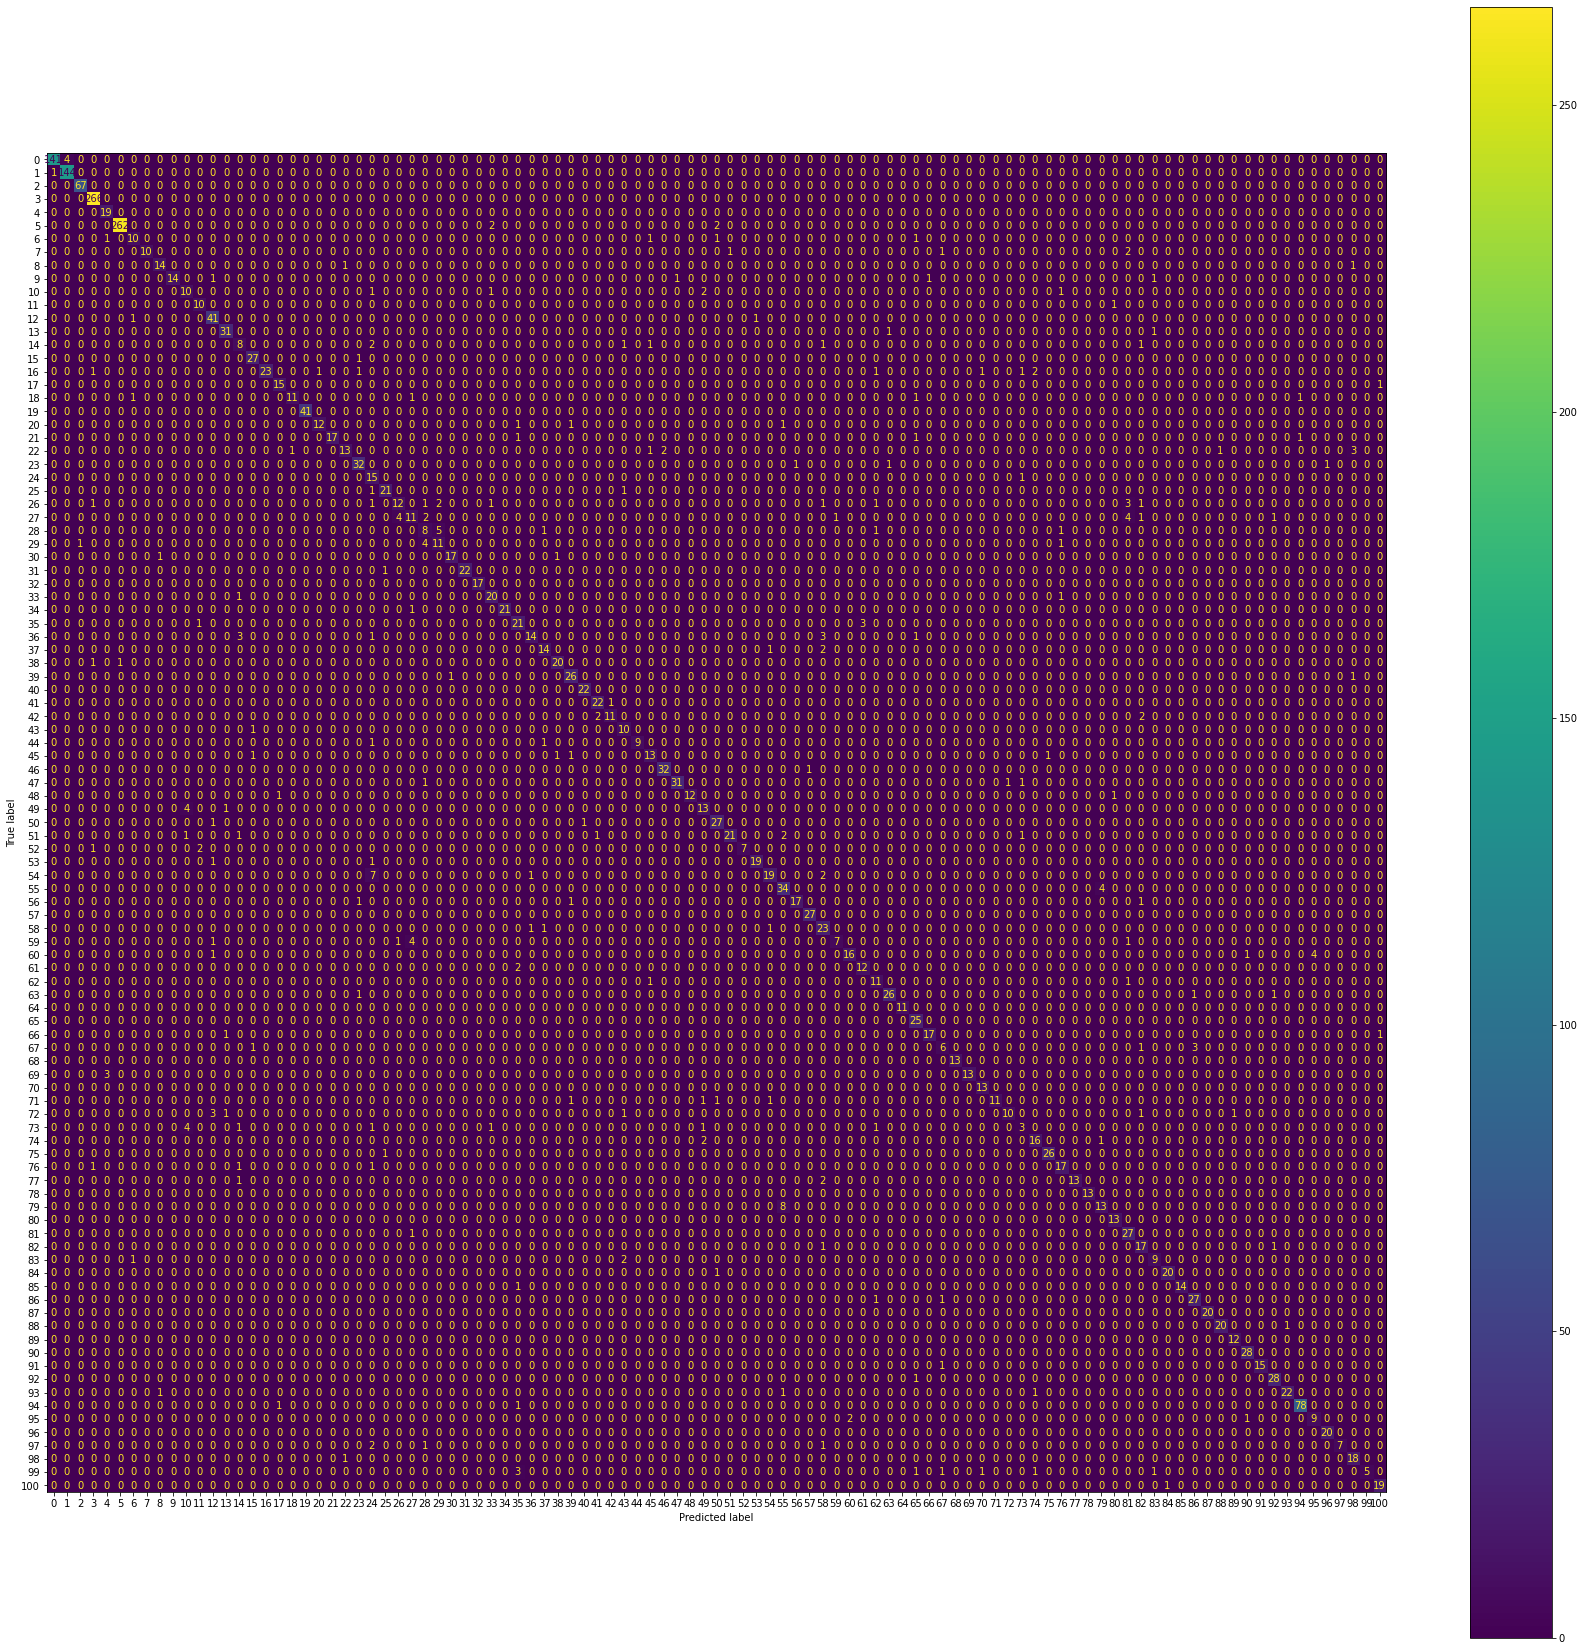

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)

In [ ]:
gc.collect()

153

ROC Curve plot

In [ ]:
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = NUM_CLASSES

In [ ]:
train_un = np.unique(y_train)

y_test = y_true
test_un = np.unique(y_test)

# Binarize the output
y_train = label_binarize(y_train, classes=train_un)
y_test = label_binarize(y_test, classes=test_un)

n_classes = y_test.shape[1]

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = label_binarize(y_pred, classes=test_un)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[i, :], y_score[i, :])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

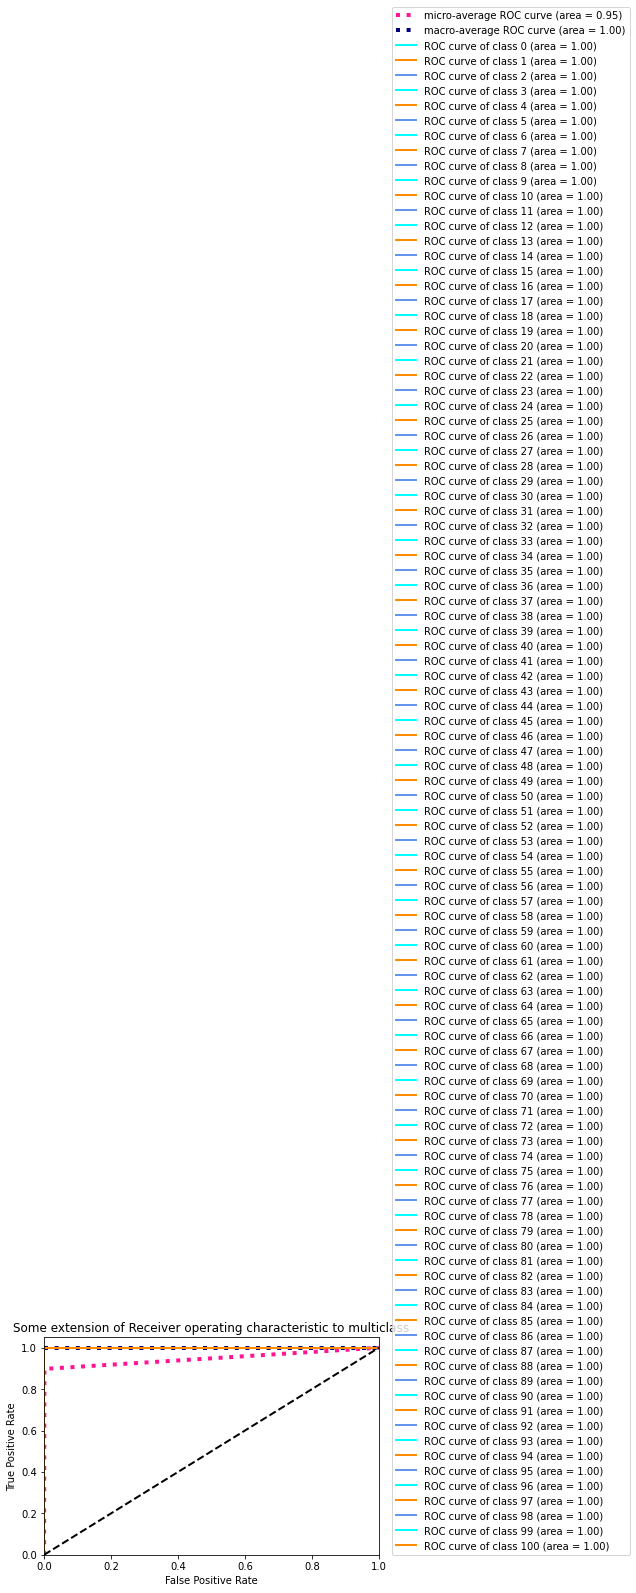

In [ ]:
lw = 2

plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc=(1.04,0))
plt.show()

In [ ]:
y_prob = y_score

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "\nOne-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "\nOne-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)


One-vs-One ROC AUC scores:
0.921389 (macro),
0.948307 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.921389 (macro),
0.948307 (weighted by prevalence)


In [ ]:
gc.collect()

24615

AUC-PRC plot

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

y_score = label_binarize(y_pred, classes=test_un)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

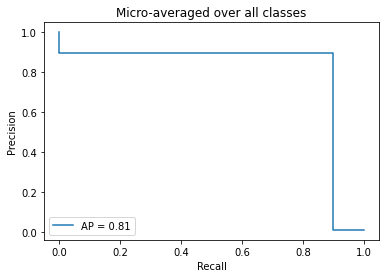

In [ ]:
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

The top-1 error rate in %

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
error_rate = 1 - accuracy

print("Error rate: {:.3}%".format(error_rate*100))

Error rate: 10.2%


Visualize model

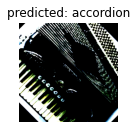

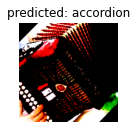

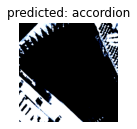

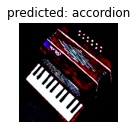

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    X, y = [], []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
           
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')

                    name = list(class_to_idx.keys())[list(class_to_idx.values()).index(preds[j])]
                    ax.set_title(f'predicted: {name}')
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

visualize_model(net)

**4.1**Вертикальні та горизонтальні лінії, темні  пікселі, об'ємність зображення,шум зображення.



**4.2** Так. Розміри оригінального зображення 224х224 пікселя, а розмірність фільтрів - 7х7. Відповідно багато інформації з картинки втарчається під час згортки. Для вирішення цього потрібно зменшити розмірність вхідного зображення та збільшити розмірність фільтрів.



**4.3** Так, на деяких фільтрах виділяється окремо об'єкт і окремо фон




**4.4** Кольори враховуються у фільтрі №7




**Train a model that achieves the test fold’s**

Результати для Frozen pre-trained ResNet


 top-1 error rate < 15%:

- Error rate: 8.64%

average accuracy ≥ 91%:

- Test Accuracy: 91.35845143449706%


Classification report:

 accuracy                           0.91      2893
   macro avg       0.89      0.87      0.87      2893
weighted avg       0.92      0.91      0.91      2893